In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random, math


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor

### Data loading

In [53]:
df_path = '/home/pc/Desktop_linux/chinu/big_mart_sales_prediction/train_v9rqX0R.csv'
unseen_path = '/home/pc/Desktop_linux/chinu/big_mart_sales_prediction/test_AbJTz2l.csv'

df = pd.read_csv(df_path)
unseen_df = pd.read_csv(unseen_path)
print(df.head())
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales
0           FDA15         9.30          Low Fat         0.016047                  Dairy  249.8092            OUT049                       1999      Medium               Tier 1  Supermarket Type1          3735.1380
1           DRC01         5.92          Regular         0.019278            Soft Drinks   48.2692            OUT018                       2009      Medium               Tier 3  Supermarket Type2           443.4228
2           FDN15        17.50          Low Fat         0.016760                   Meat  141.6180            OUT049                       1999      Medium               Tier 1  Supermarket Type1          2097.2700
3           FDX07        19.20          Regular         0.000000  Fruits and Vegetables  182.0950            OUT010                       1998  

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Missing Values

In [55]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [56]:
unseen_df.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

### Create Item weights DF for each item

In [57]:
df_weights = df[['Item_Identifier', 'Item_Weight']].dropna(axis=0)
df_weights = df_weights.groupby(by='Item_Identifier')['Item_Weight'].apply(lambda x: x.mode().iloc[0]).reset_index()
df_weights.head()

df_Item_Identifier = df.groupby(by='Item_Identifier')['Item_Outlet_Sales'].mean().reset_index()
# df_weights.head(), df_Item_Identifier.head()

### Data Preprocessing 

In [58]:
GROCERY_STORE_SIZE = df[df['Outlet_Type'] == 'Grocery Store']['Outlet_Size'].dropna().unique()[0]
LOCATION_TIER_2_SIZE = df[df['Outlet_Location_Type'] == 'Tier 2']['Outlet_Size'].dropna().unique()[0]


def replace_missing_values(row):
    if pd.isna(row['Item_Weight']):
        mode_val = df_weights.loc[df_weights['Item_Identifier'] == row['Item_Identifier'], 'Item_Weight'] 
        if not mode_val.empty:
            row['Item_Weight'] = mode_val.iloc[0]
        else:
            print(row['Item_Identifier'])
    
    if pd.isna(row['Outlet_Size']):
        if row['Outlet_Type'] == 'Grocery Store':
            row['Outlet_Size'] = GROCERY_STORE_SIZE
        elif row['Outlet_Location_Type'] == 'Tier 2':
            row['Outlet_Size'] = LOCATION_TIER_2_SIZE
        else:
            print('NaN is as it is !!', row['Outlet_Identifier'], row['Outlet_Location_Type'], row['Outlet_Type'])

    # assign 1 for low fat else 0
    my_dict = {'Low Fat' : 1,
               'Regular' : 0,
               'LF' : 1,
               'reg' : 0,
               'low fat' : 1}
    row['Item_Fat_Content'] = my_dict[row['Item_Fat_Content']]


    # Feature enginnering for establish_year
    row['Outlet_Total_Years'] = int(2013 - row['Outlet_Establishment_Year'])

    # Handle Visibility feature
    row['Item_Vis_Log'] = math.log(row['Item_Visibility'] * 1000 + 1)

    # Target Encoding for Item_Identifier
    row['Item_Identifier_encoded'] = df_Item_Identifier.loc[df_Item_Identifier['Item_Identifier'] == row['Item_Identifier'], 'Item_Outlet_Sales'].iloc[0]
    return row


df_clean = df.apply(replace_missing_values, axis=1)
unseen_df_clean = unseen_df.apply(replace_missing_values, axis=1)

df_clean['Item_Weight'] = df_clean['Item_Weight'].fillna(df_clean['Item_Weight'].mode().iloc[0])
unseen_df_clean['Item_Weight'] = unseen_df_clean['Item_Weight'].fillna(df_clean['Item_Weight'].mode().iloc[0])

df_clean.isna().sum()


FDN52
FDK57
FDE52
FDQ60
FDQ60


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Outlet_Total_Years           0
Item_Vis_Log                 0
Item_Identifier_encoded      0
dtype: int64

### Target Encoding with KFOLd for 'Item_Identifier'

In [59]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# df_clean['Item_Identifier_encoded'] = np.nan

# for i, (train_index, val_index) in enumerate(kf.split(df_clean)):
#     train_df = df_clean.iloc[train_index].copy()  # Create copies to avoid SettingWithCopyWarning
#     val_df = df_clean.iloc[val_index].copy()    # Create copies to avoid SettingWithCopyWarning

#     means = train_df.groupby('Item_Identifier')['Item_Outlet_Sales'].mean().round(2)

#     # The fix: Use the indices from val_df directly
#     df_clean.loc[val_df.index, 'Item_Identifier_encoded'] = val_df['Item_Identifier'].map(means)


# # Calculate mean for overall df_clean
# means = df_clean.groupby(by='Item_Identifier')['Item_Outlet_Sales'].mean().round(2)
# df_clean['Item_Identifier_encoded'] = df_clean['Item_Identifier_encoded'].fillna(df_clean['Item_Outlet_Sales'].mean().round(2))
# unseen_df_clean['Item_Identifier_encoded'] = unseen_df_clean['Item_Identifier'].map(means)

### One hot encoding for Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, Outlet_Type    

In [60]:
def one_hot_encoding(temp_df):
    dummies = pd.get_dummies(temp_df[['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']], dtype=int)
    new_df = pd.concat([temp_df, dummies], axis=1)
    new_df = new_df.drop(['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Establishment_Year'], axis=1)
    return new_df


df_clean = one_hot_encoding(df_clean)
unseen_df_clean = one_hot_encoding(unseen_df_clean)

### Visualization

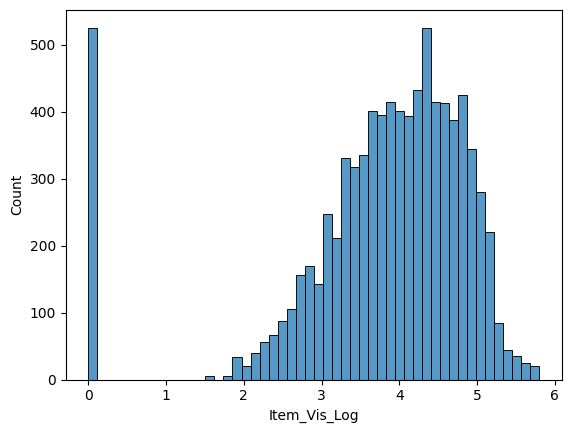

In [61]:
plt.Figure(figsize=(10, 10))
sns.histplot(data=df_clean, x='Item_Vis_Log', bins=50)
plt.show()

In [62]:
df_clean[df_clean['Item_Vis_Log'] < 1].shape

(526, 45)

### Correlation

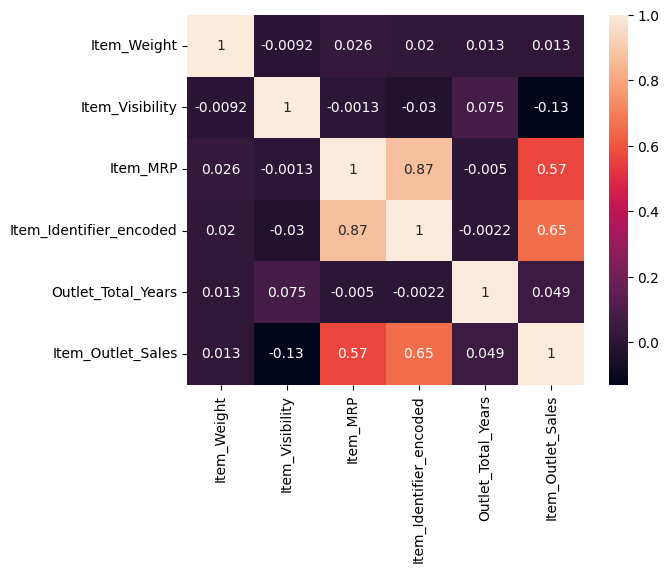

In [63]:
num_col = [ 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Identifier_encoded', 'Outlet_Total_Years','Item_Outlet_Sales']
plt.Figure(figsize=(10, 10))
sns.heatmap(df_clean[num_col].corr(), annot=True)
plt.show()

### Train- Test Split

In [64]:
y = df_clean['Item_Outlet_Sales']
X = df_clean.drop(['Item_Outlet_Sales', 'Item_Identifier', 'Item_Visibility', 'Item_Identifier_encoded'], axis=1)
X_unseen = unseen_df_clean.drop(['Item_Identifier', 'Item_Visibility', 'Item_Identifier_encoded'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_unseen.shape

((5966, 41), (2557, 41), (5966,), (2557,), (5681, 41))

### Scalling

In [65]:
scaler = StandardScaler()
scaling_col = ['Item_Weight', 'Item_Vis_Log', 'Item_MRP', 'Outlet_Total_Years']
X_train[scaling_col] = scaler.fit_transform(X_train[scaling_col])
X_unseen[scaling_col] = scaler.transform(X_unseen[scaling_col])
X_train.head()

,Item_Weight,Item_Fat_Content,Item_MRP,Outlet_Total_Years,Item_Vis_Log,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
1921,-1.131661,0,-0.401895,-0.015833,1.022949,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0
655,1.466114,1,-0.619284,0.103437,-0.843276,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
2229,-0.941632,0,-0.202535,1.534680,0.209349,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2537,1.379737,1,1.290187,-0.492914,0.841434,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
3528,1.163796,0,0.686853,1.296139,0.638205,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


### Model Evaluation

In [66]:
def model_evaluation(y_train, y_train_pred, y_test, y_test_pred, model='Regression'):
    print("*" * 80)
    print("*" * 30, model, '*' * 30)
    print("*" * 80)
    print('Train Data : ')
    print('RMSE = ', root_mean_squared_error(y_train, y_train_pred))
    print('R2_score = ', r2_score(y_train, y_train_pred))
    print('\n\nTest Data : ')
    print('RMSE = ', root_mean_squared_error(y_test, y_test_pred))
    print('R2_score = ', r2_score(y_test, y_test_pred))


### Random Forest

In [67]:
param = {
    'n_estimators': [ 50, 70, 100, 150, 200],
    'max_depth': [5, 7, 10],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15],
    'random_state': [42]
}


rf = RandomForestRegressor()

# 1. Define the RMSE function
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# 2. Create the RMSE scorer using make_scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False) # Important!

grid_search = GridSearchCV(estimator=rf,
                           scoring=rmse_scorer,  # Use the scorer here
                           verbose=2,
                           cv=4,
                           param_grid=param,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 135 candidates, totalling 540 fits
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=42; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=70, random_state=42; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=150, random_state=42; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=70, random_state=42; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=42; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=42; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=150, random_state=42; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=15, min_samples_split=10, n_estimators=70, random_state=42; total time=   

GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [50, 70, 100, 150, 200],
                         'random_state': [42]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=2)

In [68]:
best_estimator = grid_search.best_estimator_

y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)
y_unseen_pred = best_estimator.predict(X_unseen)
model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'RF')

********************************************************************************
****************************** RF ******************************
********************************************************************************
Train Data : 
RMSE =  1074.4080571630577
R2_score =  0.6096777041893305


Test Data : 
RMSE =  2733.45419627364
R2_score =  -1.667543416340723


In [69]:
best_estimator

RandomForestRegressor(max_depth=5, min_samples_leaf=15, min_samples_split=5,
                      n_estimators=50, random_state=42)

### Linear Rgression

In [70]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)

In [71]:
# y_train_pred = lr.predict(X_train)
# y_test_pred = lr.predict(X_test)
# y_unseen_pred = lr.predict(X_unseen)
# model_evaluation(y_train, y_train_pred, y_test, y_test_pred)

### Ridge Regularization

In [72]:
# param = {'alpha': np.logspace(-3, 3, 7)}

# ridge = Ridge()


# def root_mean_squared_error(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     return np.sqrt(mse)

# rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
# grid_search = GridSearchCV(estimator=ridge,
#                            param_grid=param,
#                            cv=5,
#                            scoring=rmse_scorer,
#                            n_jobs=-1,
#                            verbose=2)

# grid_search.fit(X_train, y_train)

In [73]:
# best_estimator = grid_search.best_estimator_
# y_train_pred = best_estimator.predict(X_train)
# y_test_pred = best_estimator.predict(X_test)
# y_unseen_pred = best_estimator.predict(X_unseen)
# model_evaluation(y_train, y_train_pred, y_test, y_test_pred, best_estimator)

### Lasso Regularization

In [74]:
# param = {'alpha': np.logspace(-3, 3, 7)}

# lasso = Lasso()

# def root_mean_squared_error(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     return np.sqrt(mse)


# rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
# grid_search = GridSearchCV(estimator=lasso,
#                            param_grid=param,
#                            cv=5,
#                            scoring=rmse_scorer,
#                            n_jobs=-1,
#                            verbose=2)

# grid_search.fit(X_train, y_train)

### Submission File

In [75]:
unseen_path = '/home/pc/Desktop_linux/chinu/big_mart_sales_prediction/test_AbJTz2l.csv'
unseen_df = pd.read_csv(unseen_path)

submission_df = unseen_df[['Item_Identifier', 'Outlet_Identifier']]
submission_df['Item_Outlet_Sales'] = y_unseen_pred

write_file_path = '/home/pc/Desktop_linux/chinu/big_mart_sales_prediction/submission/2nd_attempt.csv'
submission_df.to_csv(write_file_path, index=False)

/tmp/ipykernel_204040/3990787268.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['Item_Outlet_Sales'] = y_unseen_pred
